## House Prices - Advanced Regression Techniques

****** HERE WILL BE ID *******

### TL;DR

### Part 1 Imports and Definitions


In [ ]:
# import numpy, matplotlib, etc. 
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sweetviz as sw
from tqdm import tqdm


# sklearn imports
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import neural_network
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split


# define plt settings
sns.set_theme()
plt.rcParams["font.size"] = 20
plt.rcParams["axes.labelsize"] = 20
plt.rcParams["xtick.labelsize"] = 20
plt.rcParams["ytick.labelsize"] = 20
plt.rcParams["legend.fontsize"] = 20
plt.rcParams["legend.markerscale"] = 1.5
plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams["legend.title_fontsize"] = 20


- define the input and output folders


In [ ]:
input_folder = "input/"

train_data_path = os.path.join(input_folder, "train.csv")
test_data_path = os.path.join(input_folder, "test.csv")

  - define the show graphs variable


In [ ]:
SHOW_GRAPHS = True

#### Load the traning data
  - Load the csv data to variables


In [ ]:
train_data = pd.read_csv(train_data_path)

test_data = pd.read_csv(test_data_path)

# display the first few rows of the data
train_data.head()

### Part 2 Data Investigation EDA


#### Data Cleaning

- Remove the id column


In [ ]:
# Drop the "Id" column from the train_data DataFrame
train_data = train_data.drop("Id", axis=1)

# Drop the "Id" column from the test_data DataFrame
test_id = test_data["Id"]
test_data = test_data.drop("Id", axis=1)


train_data.head()

- Count the number of feuatures

In [ ]:
print(f"Number of features: {train_data.shape[1]}")

Get summary statistics for the training dataset show only the numerical columns


In [ ]:
train_data.describe()


- Get the data types of the columns in the training dataset


In [ ]:
display(train_data.info())

We can see that most of the data is object

- Check for missing values

In [ ]:
def show_missing_data_with_percentage(data):
    print("Missing values in the dataset:")
    print("-----------------------------------------")
    print("Total Rows: ", len(data))
    print("_________________________________________")
    # Display missing values in each column of the training dataset
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(train_data)) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
    missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)
    print(missing_data.head(20))
    
    print("\n\nTotal missing values: ", missing_data['Missing Values'].sum())
    
    


In [ ]:
# Display missing values in the training dataset
show_missing_data_with_percentage(train_data)

We can see that the columns "Alley", "PoolQC", "Fence", "MiscFeature" have a lot of missing values.

- Handle the missing data<br><br>
First step to remove highly missing features (by threshold)

In [ ]:
def drop_highly_missing_features(data, fetures_to_drop):
    data = data.drop(fetures_to_drop, axis=1)
    return data


def find_features_with_missing_values_threshold(data, threshold):
    missing_values = data.isnull().sum()
    missing_percentage = (missing_values / len(train_data)) * 100
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Missing Values', 'Percentage'])
    missing_data.sort_values(by='Missing Values', ascending=False, inplace=True)
    features_to_drop = missing_data[missing_data['Percentage'] > threshold].index
    return features_to_drop


In [ ]:
# Set the threshold for missing values to remove
threshold = 80
# for 80 it return # ["Alley", "PoolQC", "Fence", "MiscFeature"]
drop_features = find_features_with_missing_values_threshold(train_data, threshold) 


train_data = drop_highly_missing_features(train_data, drop_features)

test_data = drop_highly_missing_features(test_data, drop_features)

print("Remove this features: ", drop_features)

In [ ]:
show_missing_data_with_percentage(train_data)

Handling Missing Values for Numerical Features

In [ ]:
# fill missing numerical values with median
def handle_missing_values_numerical(data):
    for column in data.select_dtypes(include=[np.number]).columns:
        data[column].fillna(data[column].median(), inplace=True)
    return data

Handling Missing Values for Categorical Features

In [ ]:
# Fill missing categorical values with most frequent value
def handle_missing_values_categorical(data):
    for column in data.select_dtypes(include=[object]).columns:
        data[column].fillna(data[column].mode()[0], inplace=True)
    return data

One function to handle the missing values

In [ ]:
def handle_missing_values(data):
    data = handle_missing_values_numerical(data)
    data = handle_missing_values_categorical(data)
    return data

In [ ]:
# fill the missing values in the train data
train_data = handle_missing_values(train_data)

# fill the missing values in the test data
test_data = handle_missing_values(test_data)

Verify No More Missing Values

In [ ]:
print("\nMissing values in the training dataset after filling:")
print(train_data.isnull().sum().sum())

print("\nMissing values in the test dataset after filling:")
print(test_data.isnull().sum().sum())


In [ ]:
train_data.head()

Convert Categorical Features to Numeric Using One-Hot Encoding

In [ ]:
print("Data types in training data:")
print(train_data.dtypes)


In [ ]:
# Identify categorical columns
categorical_columns = train_data.select_dtypes(include=['object']).columns

# Use one hot encoding to convert categorical columns to numerical columns
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns)
test_data_encoded = pd.get_dummies(test_data, columns=categorical_columns)

# Save the target variable (SalePrice) and then drop it from train_data_encoded before alignment
sale_price = train_data_encoded['SalePrice']
train_data_encoded = train_data_encoded.drop('SalePrice', axis=1)

# Align train and test data to ensure they have the same columns
train_data_encoded, test_data_encoded = train_data_encoded.align(test_data_encoded, join='inner', axis=1)

# Reattach the SalePrice column to train_data_encoded
train_data_encoded['SalePrice'] = sale_price


In [ ]:
# Reassigning the encoded DataFrame back to the original variable
train_data = train_data_encoded
test_data = test_data_encoded

# Display the first few rows of the training data after encoding
train_data.head()

#### Feature Analysis & Visualization 

Descriptive Statistics

In [ ]:
desc_stats = train_data.describe()
print("Descriptive Statistics:\n", desc_stats)


Histogram for SalePrice

In [ ]:
if SHOW_GRAPHS:
    fig = px.histogram(train_data, x='SalePrice', title='Distribution of SalePrice')
    fig.show()

We can see the distribution of SalePrice

- Box plot for SalePrice

In [ ]:
if SHOW_GRAPHS:
    fig = px.box(train_data, y='SalePrice', title='Boxplot of SalePrice')
    fig.show()

GrLivArea: Above grade (ground) living area square feet

In [ ]:
if SHOW_GRAPHS:
    fig = px.scatter(train_data, x='GrLivArea', y='SalePrice', title='GrLivArea vs SalePrice')
    fig.show()


In [ ]:
if SHOW_GRAPHS:
    fig = px.scatter(train_data, x='GrLivArea', y='SalePrice', marginal_x='histogram', marginal_y='histogram', title='Joint Plot of GrLivArea vs SalePrice')
    fig.show()

TotalBsmtSF: Total square feet of basement area

In [ ]:
if SHOW_GRAPHS:
    fig = px.scatter(train_data, x='TotalBsmtSF', y='SalePrice', title='TotalBsmtSF vs SalePrice')
    fig.show()

OverallQual: Rates the overall material and finish of the house

In [ ]:

if SHOW_GRAPHS:
    overall_qual_mean = train_data.groupby('OverallQual')['SalePrice'].mean()
    fig = px.bar(overall_qual_mean, x=overall_qual_mean.index, y='SalePrice', title='OverallQual vs SalePrice')
    fig.add_trace(go.Scatter(x=overall_qual_mean.index, y=overall_qual_mean.values, mode='lines', name='lines'))
    fig.show()


Display the correlation matrix with the n most correlated features


In [1113]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_top_correlated_features(train_data, n=5):
    """
    Displays a heatmap for the top n features most correlated with 'SalePrice'.
    
    Parameters:
    - train_data: DataFrame containing the training data.
    - n: The number of top features to consider for the heatmap.
    """
    # Calculate the correlation matrix
    correlation_matrix = train_data.corr()
    
    # Find the top n features most correlated with 'SalePrice', excluding 'SalePrice' itself
    top_n_features = correlation_matrix['SalePrice'].abs().sort_values(ascending=False)[1:n+1].index
    
    # Filter the correlation matrix to include only the top n features
    top_n_corr_matrix = train_data[top_n_features].corr()
    
    # Plotting
    plt.figure(figsize=(15, 10))  # Adjust the figure size as needed
    sns.heatmap(top_n_corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Top {n} Features Correlated with SalePrice')
    plt.show()                

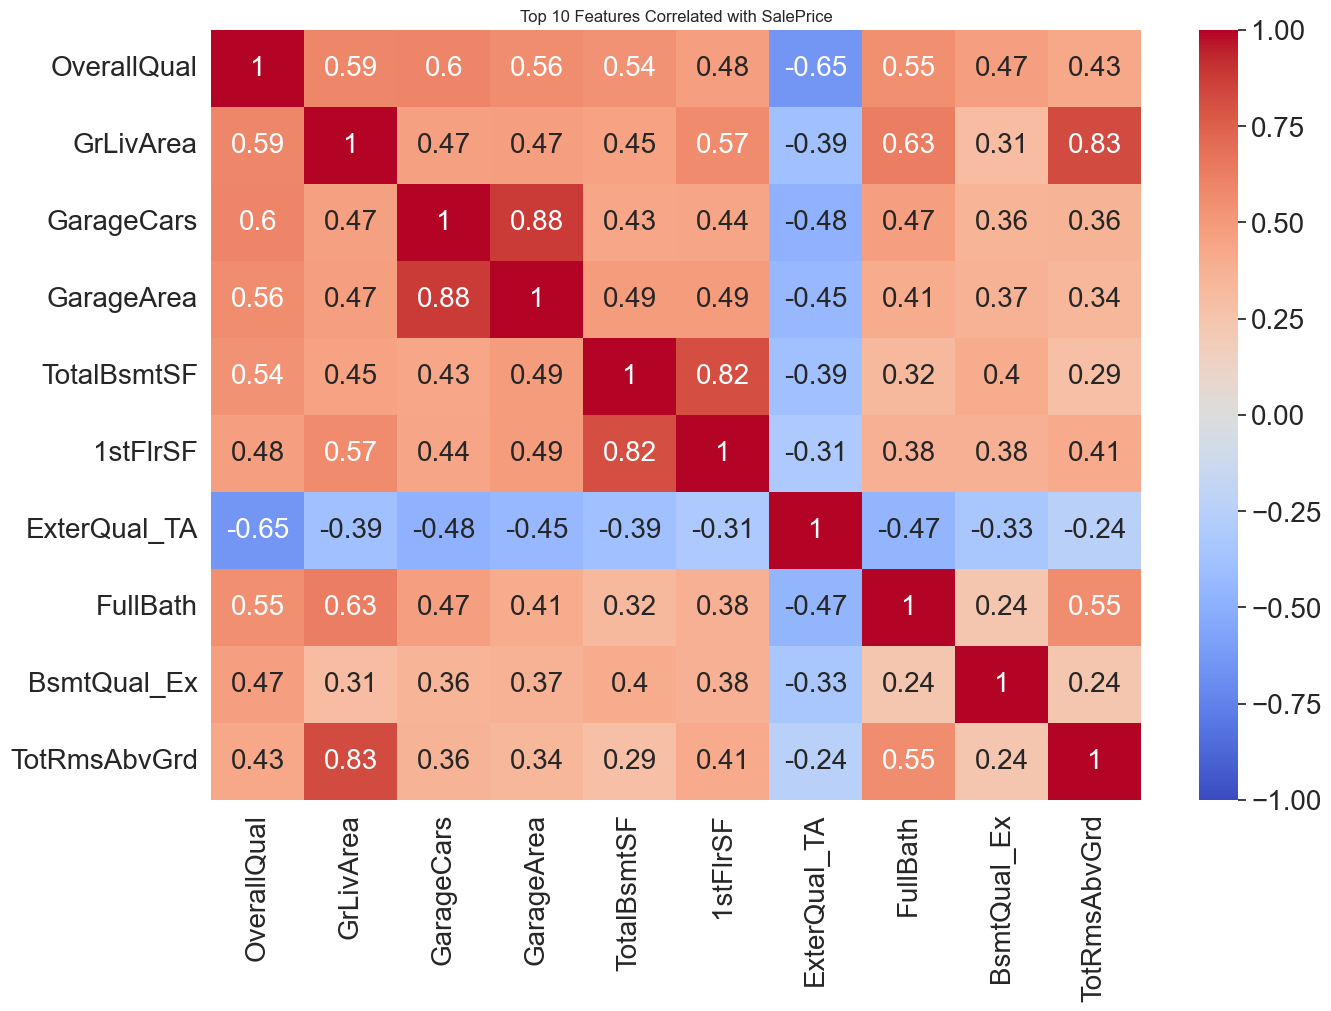

In [1115]:
if SHOW_GRAPHS:
    show_top_correlated_features(train_data, n=10)